# Denoising Diffusion Probabilistic Model (DDPM)

text credits:
- ysda generative models course

code credits:
- hf post

In [34]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

/Users/a.n.veselev/miniconda3/envs/work/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

data = FashionMNIST(
    root="data",
    train=True,
    transform=transforms.Compose([transforms.Resize(28), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
    download=True
)

In [16]:
# utility functions
# it'll help later
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


#### Schedulers

In [17]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [ ]:
# Visualise some schedulers

In [ ]:
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

### Forward Diffusion

**Forward process** is defined as a posterior distribution $q(\mathbf{x}_{1:T}|\mathbf{x}_0)$.

It is a Markov chain, which consequently adds gaussian noise to a given object $\mathbf{x}_0$.

At every step of this process the gaussian noise is added with different magnitude, which is determined with a schedule of variances $\{\beta_1, ... \beta_T\}$.
If this schedule is chosen properly and T goes to infinity (or is large enough), we will converge to pure noise $\mathcal{N}(0, I)$.

Markov chain is defined by:
$$
 q(\mathbf{x}_t | \mathbf{x}_{t - 1}) = \mathcal{N}(\mathbf{x}_t | \sqrt{1 - \beta_t}\mathbf{x}_{t - 1}, \beta_t \mathbf{I}), \quad q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t = 1}^T q(\mathbf{x}_t | \mathbf{x}_{t - 1})
$$

In order to get $\mathbf{x}_t$ we have to compute $\mathbf{x}_1, ..., \mathbf{x}_{t - 1}$ iteratively.

Hopefully, due to the properties of the gaussian distribution we can do it more efficiently.

Let's denote
$\alpha_t = 1- \beta_t$ and $\bar{\alpha}_t= \prod_{s = 1}^t\alpha_s$.
Then
$$
q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t|\sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1-\bar{\alpha}_t) \mathbf{I}).
\tag{1}
$$

Here we could get very useful expression
$$
    \mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1-\bar{\alpha}_t} \cdot \boldsymbol{\epsilon}. \tag{2}
$$

In [ ]:
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    # Use formula (2) to get the result
    return None

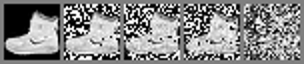

In [24]:
import torchvision

ims = [data[0][0]]

for t in [10, 20, 30, 100]:
    im = data[0][0]
    t = torch.Tensor([t]).long()
    ims.append(q_sample(im, t, noise=None))

i = torchvision.transforms.functional.to_pil_image((torchvision.utils.make_grid(torch.stack(ims), nrow=5) + 1.0) / 2.0)
i.resize((i.size[0] * 2, i.size[1] * 2))

### Reverse Diffusion

**Reverse process** consequently denoises pure gaussian noise $\mathcal{N}(0, \mathbf{I})$ until we do not get the object from the original distribution $\pi(\mathbf{x})$.

It is a probability model with latent variables
$p(\mathbf{x}_0 | \boldsymbol{\theta}) := \int p(\mathbf{x}_{0:T} | \boldsymbol{\theta}) d\mathbf{x}_{1:T}$,
where
- latents $\mathbf{z} = \{\mathbf{x}_1, ..., \mathbf{x}_T \}$ correspond to noised objects
- $\mathbf{x}_0$ is an object from the original distribution $\pi(\mathbf{x})$.

Joint distribution $p(\mathbf{x}_{0:T} | \boldsymbol{\theta})$ is called reverse diffusion process, which is essentially a Markov chain of gaussian distributions $p(\mathbf{x}_t|\mathbf{x}_t, \boldsymbol{\theta})$:
$$
p(\mathbf{x}_{0:T}) = p(\mathbf{x}_T) \prod_{t = 1}^T p(\mathbf{x}_{t-1}|\mathbf{x}_t, \boldsymbol{\theta}), \quad p(\mathbf{x}_{T} | \boldsymbol{\theta})=\mathcal{N}(0, \mathbf{I})
$$
$$
  p(\mathbf{x}_{t - 1}|\mathbf{x}_t | \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t)). \tag{3}
$$

In Lecture 10 we have derived ELBO for this model:

$$
    \mathcal{L}(q, \boldsymbol{\theta}) =  \mathbf{E}_{q} \Bigl[\log p(\mathbf{x}_0 | \mathbf{x}_1, \boldsymbol{\theta}) - KL\bigl(q(\mathbf{x}_T | \mathbf{x}_0) || p(\mathbf{x}_T)\bigr)
    - \sum_{t=2}^T \underbrace{KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)}_{\mathcal{L}_t} \Bigr].
$$

Here we use the following distribution $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}( \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $, where
$$
\boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0
\tag{4}
$$
$$
\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t
\tag{5}
$$

(These scary formulas are not difficult to derive, follow the link to find details [Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239)).

Now our goal is to define parameters $\boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t), \boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t)$ of reverse diffusion.

#### Variance
Our first assumption is to set the variance $\boldsymbol{\sigma}^2_{\boldsymbol{\theta}, t}(\mathbf{x}_t) = \tilde{\beta}_t$. This is very native assumption

#### Mean
Here we will use the expression (2) to get $\mathbf{x}_0$ from $\mathbf{x}_t$:
$$
    \mathbf{x}_0 = \frac{\mathbf{x}_t - \sqrt{1 - \bar{\alpha}_{t}} \cdot \boldsymbol{\epsilon}}{\sqrt{\bar{\alpha}_{t}}}.
    \tag{6}
$$

If we put this expression to the formula (4) we will get:
$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon} \right).\tag{7}
$$

So the idea here to parametrize the model mean in the same functional form:
$$
    \boldsymbol{\mu}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) \right).\tag{8}
$$

**Note:** our model will predict the noise which was applied to $\mathbf{x}_0$ to get $\mathbf{x}_t$.

In [ ]:
# calculations for posterior q(x_{t-1} | x_t, x_0)
# use equation (5)
posterior_variance = None

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Use equation (8)
    model_mean = None

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 


In [46]:
# Sampling Algorithm
@torch.no_grad()
def p_sample_loop(model, shape, verbose=False):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    it = reversed(range(0, timesteps))
    if verbose:
        it = tqdm(it, desc='sampling loop time step', total=timesteps)
    for i in it:
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3, verbose=False):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size), verbose=verbose)

Let return to the ELBO. The main part of it is:
$$
    \mathcal{L}_t = KL \bigl(q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) || p(\mathbf{x}_{t - 1} | \mathbf{x}_t, \boldsymbol{\theta} )\bigr)
$$

It can be transformed to:

$$
    \mathcal{L}_t = \mathbf{E}_{\boldsymbol{\epsilon}} \left[ \frac{\beta_t^2}{2 \tilde{\beta_t} \alpha_t (1 - \bar{\alpha}_t)} \| \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t) \|^2 \right].
$$

In practice this loss is simplified. Particilarly, we will omit coefficient of the norm and we will sample index $t$ at each training step.

Finally, we will train our model with the following objective:
$$
\text{loss} = \mathbf{E}_{\mathbf{x}_0, \boldsymbol{\epsilon}, t}\bigg[ \|\boldsymbol{\epsilon} - \boldsymbol{\epsilon}_{\boldsymbol{\theta}, t}(\mathbf{x}_t)\|^2\bigg],
$$
where $\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}$.

In [26]:
def p_losses(denoise_model, x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)
    loss = F.mse_loss(noise, predicted_noise)
    return loss

### Model architecture

(text on model architeture is copied from [annotated diffusion](https://huggingface.co/blog/annotated-diffusion))

In [27]:
# Network helpers
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Position embeddings

As the parameters of the neural network are shared across time (noise level), the authors employ sinusoidal position embeddings to encode $t$, inspired by the Transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)). This makes the neural network "know" at which particular time step (noise level) it is operating, for every image in a batch.

The `SinusoidalPositionEmbeddings` module takes a tensor of shape `(batch_size, 1)` as input (i.e. the noise levels of several noisy images in a batch), and turns this into a tensor of shape `(batch_size, dim)`, with `dim` being the dimensionality of the position embeddings. This is then added to each residual block, as we will see further.

In [28]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet/ConvNeXT block

Next, we define the core building block of the U-Net model. The DDPM authors employed a Wide ResNet block ([Zagoruyko et al., 2016](https://arxiv.org/abs/1605.07146)), but Phil Wang decided to also add support for a ConvNeXT block ([Liu et al., 2022](https://arxiv.org/abs/2201.03545)), as the latter has achieved great success in the image domain. One can choose one or another in the final U-Net architecture.

In [29]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

### Attention module

Next, we define the attention module, which the DDPM authors added in between the convolutional blocks. Attention is the building block of the famous Transformer architecture ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)), which has shown great success in various domains of AI, from NLP and vision to [protein folding](https://www.deepmind.com/blog/alphafold-a-solution-to-a-50-year-old-grand-challenge-in-biology). Phil Wang employs 2 variants of attention: one is regular multi-head self-attention (as used in the Transformer), the other one is a [linear attention variant](https://github.com/lucidrains/linear-attention-transformer) ([Shen et al., 2018](https://arxiv.org/abs/1812.01243)), whose time- and memory requirements scale linear in the sequence length, as opposed to quadratic for regular attention.

For an extensive explanation of the attention mechanism, we refer the reader to Jay Allamar's [wonderful blog post](https://jalammar.github.io/illustrated-transformer/).

In [30]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization

The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization ([Wu et al., 2018](https://arxiv.org/abs/1803.08494)). Below, we define a `PreNorm` class, which will be used to apply groupnorm before the attention layer, as we'll see further. Note that there's been a [debate](https://tnq177.github.io/data/transformers_without_tears.pdf) about whether to apply normalization before or after attention in Transformers.

In [31]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net

Now that we've defined all building blocks (position embeddings, ResNet/ConvNeXT blocks, attention and group normalization), it's time to define the entire neural network. Recall that the job of the network \\(\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)\\) is to take in a batch of noisy images + noise levels, and output the noise added to the input. More formally:

- the network takes a batch of noisy images of shape `(batch_size, num_channels, height, width)` and a batch of noise levels of shape `(batch_size, 1)` as input, and returns a tensor of shape `(batch_size, num_channels, height, width)`

The network is built up as follows:
* first, a convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
* next, a sequence of downsampling stages are applied. Each downsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + a downsample operation
* at the middle of the network, again ResNet or ConvNeXT blocks are applied, interleaved with attention
* next, a sequence of upsampling stages are applied. Each upsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + an upsample operation
* finally, a ResNet/ConvNeXT block followed by a convolutional layer is applied.

Ultimately, neural networks stack up layers as if they were lego blocks (but it's important to [understand how they work](http://karpathy.github.io/2019/04/25/recipe/)).


In [32]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

---

In [ ]:
image_size = 28
channels = 1
batch_size = 128
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)

Or we can skip all this fuss and do something like `from library import cool_model`

In [ ]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size=image_size,           # the target image resolution
    in_channels=channels,            # the number of input channels, 3 for RGB images
    out_channels=channels,           # the number of output channels
    layers_per_block=2,       # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64), # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",        # a regular ResNet downsampling block
        "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",          # a regular ResNet upsampling block
      ),
)

class Unet2DModelWrapper(nn.Module):
    def __init__(self, unet):
        self.unet = unet
    
    def forward(self, x, t):
        return self.unet(x, t).sample

model = Unet2DModelWrapper(unet)
print(model.unet)

In [ ]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [ ]:
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

epochs = 6
save_and_sample_every = 1000

print(f"Training for {epochs} epochs")
print(f"{len(dataloader)} steps for each epoch")
print(f"{epochs * len(dataloader)} total steps")

for epoch in range(epochs):
    print(f"Epoch {epoch + 1} of {epochs}")
    for step, (batch, _) in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch.shape[0]
      batch = batch.to(device)

      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t)

      if step % 100 == 0:
        print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        samples = sample(model, image_size=image_size, batch_size=64, channels=channels, verbose=False)
        to_pil_image(make_grid((samples[-1] + 1.0) / 2.0)).save(f'sample-{milestone}.png')

In [ ]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels, verbose=True)

# show a random one
random_index = 5
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")